# Background Detail Binary - Story 2

This notebook assesses inter-annotator agreement for the background detail/information amount score. 
It imports pre-processed JSON files to perform a number of statistical tests to assess IAA. 


##### Imports and packages

In [12]:
# Imports and Packages:

import json # json library
import os # for list directories 

from collections import Counter # counter library
import re # regex

import numpy as np 
import math
import matplotlib.pyplot as plt

import itertools
from itertools import permutations # library to print permutations
from itertools import combinations # library to print combinations

import sklearn # sklearn for inter-annotation kappa scores
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

import scipy.stats
from scipy.stats import mode 
from scipy.stats import zscore # normalise data
from scipy.stats import mannwhitneyu # for Mann-Whitney U test
from scipy.stats import ttest_ind # independent t-test
from scipy.stats import spearmanr # spearmans rank
from scipy.stats import pearsonr # pearson's r


##### Import JSON data

In [2]:
# Import JSON data from Prolific Study

path_to_jsonFiles = "Annotations_Prolific/Background_Detail_Binary_Story2/Processed_Data" # This is the folder with the json data files
corpus = {} # init a dict to hold each json data file
participantNum = 1 # init a participant num counter

for file in sorted(os.listdir(path_to_jsonFiles)):
    if file.endswith('.json'): # check that the file has a json extension (to circumvent hidden .DS_store files)
        full_file_name = "%s/%s" % (path_to_jsonFiles, file)
        with open(full_file_name, 'r') as fi:
            storyName = "participant" + str(participantNum)
            story_data = json.load(fi)
            corpus[storyName] = story_data
        participantNum += 1
    
# all_stories holds all the json data files, with key "storyN" and value is the read in json file


In [3]:
# check that the data was read in correctly
#corpus['participant10']


##### Get annotator pair combinations as pairs of names in a list

In [4]:
# Combinations of annotators:
# Function to get the combinations of all participants

def get_combinations_of_annotators(all_annotation_data):
    """
    Takes: a dict containing all annotation data - this is the input of reading in all json files,
            as is done above.
    Returns: a list of tuples containing pairs of strings that indicate annotators. In other words, a list of 
            annotator pairs.
    """
    annotators = [] # init a list to store annotators
    annotator_pairs = [] # init a list to store all combination pairs
    
    for annotator, annotation_data in all_annotation_data.items():
        annotators.append(annotator)
     
    combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
    
    for ann in list(combs):
        annotator_pairs.append(ann)
    
    return annotator_pairs



In [5]:
# Get all annotator combinations
combinations_all_participants = get_combinations_of_annotators(corpus)


In [6]:
#print(combinations_all_participants)

##### Store the annotation values per annotator in a dictionary and list of lists for easier analysis

In [13]:
# get a list of all values per participant, put in a dict "background_values"

background_values = {}

for participant, story_info in corpus.items():
    values = [] # init values list
    for page, page_info in story_info.items():
        for panel, panel_info in page_info.items():
            background_info = panel_info["background/setting"]
            value = float(background_info["information_amount"])
            values.append(value)
    
    background_values[participant] = values
    
#background_values  


In [14]:
#background_values

# put all sets of background values into a list of lists

list_of_lists_of_all_participant_values = []
for participant, values_list in background_values.items():
    #print(participant)
    #print(values_list)
    list_of_lists_of_all_participant_values.append(values_list)
    
print(len(list_of_lists_of_all_participant_values))


10


### Krippendorff's Alpha

##### Function to calculate Krippendorff's Alpha

In [16]:
# Krippendorff's Alpha - Inter-rater agreement measure

# Code from https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Python implementation of Krippendorff's alpha -- inter-rater reliability
    (c)2011-17 Thomas Grill (http://grrrr.org)
    Python version >= 2.4 required

    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to 
    coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.


##### Krippendorff's Alpha result for all-against-all annotators, using the above function 

In [10]:
kalpha = krippendorff_alpha(list_of_lists_of_all_participant_values, nominal_metric) # get the k alpha for each ind agent
print(kalpha)



0.5234097014190681


##### Krippendorff's Alpha result for all-against-all annotators, using the Krippendorff 0.7.0 Python package

In [11]:
from krippendorff.krippendorff import alpha
print(krippendorff.alpha(list_of_lists_of_all_participant_values, level_of_measurement="nominal"))


0.5234097014190682


##### Krippendorff's Alpha results for all individual annotator pairs

In [17]:
KA_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    KA_value = krippendorff_alpha([background_values[ann1], background_values[ann2]])
    KA_values.append(KA_value)
    
print("Pairwise KA values: \n")
print(KA_values)
print("\n")
print("mean: ", np.mean(KA_values))
print("std: ", np.std(KA_values))

#print(background_values[ann1])

Pairwise KA values: 

[0.7393162393162394, 0.6187500000000001, 0.419047619047619, 0.5986842105263157, 0.5481481481481482, 0.4263322884012538, 0.4916666666666667, 0.6702702702702703, 0.5383783783783784, 0.6187500000000001, 0.6702702702702703, 0.44545454545454544, 0.8021621621621622, 0.3017689906347555, 0.615546218487395, 0.9319955406911928, 0.7959866220735786, 0.42872008324661803, 0.35924369747899154, 0.5556711758584807, 0.5383783783783784, 0.7436974789915967, 0.5538140020898641, 0.5538140020898641, 0.38795986622073575, 0.608974358974359, -0.016666666666666607, 0.5538140020898641, 0.7324561403508771, 0.5986842105263157, 0.5239687848383501, 0.17136886102403337, 0.3482905982905983, 0.5040650406504066, 0.362369337979094, 0.23750000000000016, 0.6812957157784744, 0.7324561403508771, 0.5986842105263157, 0.28994708994708995, 0.23750000000000016, 0.23750000000000016, 0.5481481481481482, 0.5481481481481482, 0.7227272727272727]


mean:  0.5238901833014862
std:  0.1867542064766771


### Per-panel analysis of annotator agreement

##### Get all annotators raw values and z-score normalised values per panel 

In [24]:
# z-score normalisation - normalise the raw background values

zscore_values = {}

for participant, values in background_values.items():
    int_values =  [float(i) for i in values]
    normalised_values = zscore(int_values)
    
    zscore_values[participant] = list(normalised_values)
    

In [25]:
#zscore_values['participant10']

In [26]:
# Get each zscore value per panel 

zscores_per_panel = {}

for participant, values in zscore_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if zscores_per_panel.get(panelName) == None:
            zscores_per_panel[panelName] = []
        if zscores_per_panel.get(panelName) != None:
            zscores_per_panel[panelName].append(val)
        panelNum += 1


In [27]:
#zscores_per_panel[1]

In [28]:
# just means in a list without panel - 1-5

binary_story2_just_means_normalised = []

for panel, values in zscores_per_panel.items():
    mean_value = np.mean(values)
    binary_story2_just_means_normalised.append(mean_value)


In [29]:
binary_story2_just_means_normalised

[0.11862535581915479,
 0.9419359498319452,
 -0.9042981164200679,
 -0.08496697418430788,
 0.7243161844172918,
 -0.698995601074986,
 -0.9042981164200679,
 -0.698995601074986,
 -0.09358478223535593,
 0.5216628447745018,
 -0.08723616451454101,
 -0.29888729758043775,
 -0.08147878373489509,
 1.1472384651770269,
 0.7306648021381068,
 -0.7016447767772778,
 0.7280156264358153,
 1.1472384651770269,
 0.9471343256229771,
 -0.4980524467738151,
 1.1472384651770269,
 0.732374987479726,
 -0.4963422614321959,
 -0.698995601074986,
 1.1472384651770269,
 0.7355831681706316,
 -0.9042981164200679,
 -0.9042981164200679,
 -0.9042981164200679,
 -0.9042981164200679,
 -0.9042981164200679]

In [30]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)


In [31]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)


In [32]:
#STD_per_panel

In [33]:
# just stds in a list without panel

binary_story2_just_stds_normalised = []

for panel, std in STD_per_panel.items():
    binary_story2_just_stds_normalised.append(std)
    

In [34]:
binary_story2_just_stds_normalised

[0.9295639044873146,
 0.7532486755986314,
 0.1824302142668824,
 1.0610180950055585,
 0.7386598629088025,
 0.5169773472016651,
 0.1824302142668824,
 0.5169773472016651,
 0.8568463396135542,
 0.8555003730120362,
 0.8921392707166538,
 0.8653239758129548,
 0.9404461186249168,
 0.2080753860952063,
 0.7726319567404795,
 0.6518970700185909,
 0.8730631112131676,
 0.2080753860952063,
 0.6894234534549756,
 0.7395132306839202,
 0.2080753860952063,
 0.7884299318020768,
 0.6657818494964468,
 0.5169773472016651,
 0.2080753860952063,
 0.7907663162571908,
 0.1824302142668824,
 0.1824302142668824,
 0.1824302142668824,
 0.1824302142668824,
 0.1824302142668824]

In [35]:

# Get raw background values value per panel 

raw_value_per_panel = {}

for participant, values in background_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if raw_value_per_panel.get(panelName) == None:
            raw_value_per_panel[panelName] = []
        if raw_value_per_panel.get(panelName) != None:
            raw_value_per_panel[panelName].append(val)
        panelNum += 1



In [36]:
#raw_value_per_panel

In [37]:
# just means in a list without panel - 1-5

binary_story2_just_means_normalised = []

for panel, values in raw_value_per_panel.items():
    mean_value = np.mean(values)
    binary_story2_just_means_normalised.append(mean_value)


In [38]:
binary_story2_just_means_normalised

[3.0,
 4.6,
 1.0,
 2.6,
 4.2,
 1.4,
 1.0,
 1.4,
 2.6,
 3.8,
 2.6,
 2.2,
 2.6,
 5.0,
 4.2,
 1.4,
 4.2,
 5.0,
 4.6,
 1.8,
 5.0,
 4.2,
 1.8,
 1.4,
 5.0,
 4.2,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

##### Calculate percentage of agreement between annotators, per panel 

In [39]:
# Get percentage agree from background_values

percentage_agreement_per_panel = {}

for panelNum, values in raw_value_per_panel.items():
    Empty_counter = 0
    Detail_counter = 0
    for val in values:
        if val == 1.0:
            Empty_counter += 1
        if val == 5.0:
            Detail_counter += 1
    #print("Empty: ", Empty_counter)
    #print("Detail: ", Detail_counter)
    if Empty_counter == 0:
        percentage_agree = 1.0
    if Detail_counter == 0:
        percentage_agree = 1.0
    else:
        if Empty_counter > Detail_counter:
            percentage_agree = abs(Empty_counter*.10)
        else:
            percentage_agree = abs(Detail_counter*.10)
    #print(percentage_agree)
    percentage_agreement_per_panel[panelNum] = {"Empty" : Empty_counter, "Detail" : Detail_counter, "Agreement" :percentage_agree}



In [40]:
percentage_agreement_per_panel


{1: {'Empty': 5, 'Detail': 5, 'Agreement': 0.5},
 2: {'Empty': 1, 'Detail': 9, 'Agreement': 0.9},
 3: {'Empty': 10, 'Detail': 0, 'Agreement': 1.0},
 4: {'Empty': 6, 'Detail': 4, 'Agreement': 0.6000000000000001},
 5: {'Empty': 2, 'Detail': 8, 'Agreement': 0.8},
 6: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 7: {'Empty': 10, 'Detail': 0, 'Agreement': 1.0},
 8: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 9: {'Empty': 6, 'Detail': 4, 'Agreement': 0.6000000000000001},
 10: {'Empty': 3, 'Detail': 7, 'Agreement': 0.7000000000000001},
 11: {'Empty': 6, 'Detail': 4, 'Agreement': 0.6000000000000001},
 12: {'Empty': 7, 'Detail': 3, 'Agreement': 0.7000000000000001},
 13: {'Empty': 6, 'Detail': 4, 'Agreement': 0.6000000000000001},
 14: {'Empty': 0, 'Detail': 10, 'Agreement': 1.0},
 15: {'Empty': 2, 'Detail': 8, 'Agreement': 0.8},
 16: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 17: {'Empty': 2, 'Detail': 8, 'Agreement': 0.8},
 18: {'Empty': 0, 'Detail': 10, 'Agreement': 1.0},
 19: {'Empty': 

In [41]:

panel_percentage_agreement = {}

for panel, info in percentage_agreement_per_panel.items():
    panel_percentage_agreement[panel] = info["Agreement"]



In [42]:
panel_percentage_agreement

{1: 0.5,
 2: 0.9,
 3: 1.0,
 4: 0.6000000000000001,
 5: 0.8,
 6: 0.9,
 7: 1.0,
 8: 0.9,
 9: 0.6000000000000001,
 10: 0.7000000000000001,
 11: 0.6000000000000001,
 12: 0.7000000000000001,
 13: 0.6000000000000001,
 14: 1.0,
 15: 0.8,
 16: 0.9,
 17: 0.8,
 18: 1.0,
 19: 0.9,
 20: 0.8,
 21: 1.0,
 22: 0.8,
 23: 0.8,
 24: 0.9,
 25: 1.0,
 26: 0.8,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0}

##### Sort by least agreed to most agreed panel

In [43]:
import operator
sorted_agreement_per_panel = sorted(panel_percentage_agreement.items(), key=operator.itemgetter(1))

print(sorted_agreement_per_panel)



[(1, 0.5), (4, 0.6000000000000001), (9, 0.6000000000000001), (11, 0.6000000000000001), (13, 0.6000000000000001), (10, 0.7000000000000001), (12, 0.7000000000000001), (5, 0.8), (15, 0.8), (17, 0.8), (20, 0.8), (22, 0.8), (23, 0.8), (26, 0.8), (2, 0.9), (6, 0.9), (8, 0.9), (16, 0.9), (19, 0.9), (24, 0.9), (3, 1.0), (7, 1.0), (14, 1.0), (18, 1.0), (21, 1.0), (25, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 1.0), (31, 1.0)]


## Pearson's r and Spearman's rank between annotator pairs

##### Calculate Pearson's r scores between each annotator pair

In [44]:
# Pearson's r function 

def get_pearsonsr(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    
    # compare samples
    coef, p = pearsonr(values_Ann1, values_Ann2)
    print('Pearsons correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    
    return coef, p


In [45]:
corr = 0
not_corr = 0

pearsons_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values.append(pearsons_value)
    
print(pearsons_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(pearsons_values))
print("std: ", np.std(pearsons_values))


Pearsons correlation coefficient: 0.743
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.640
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.411
Samples are uncorrelated (fail to reject H0) p=0.022
Pearsons correlation coefficient: 0.622
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.542
Samples are correlated (reject H0) p=0.002
Pearsons correlation coefficient: 0.455
Samples are uncorrelated (fail to reject H0) p=0.010
Pearsons correlation coefficient: 0.490
Samples are correlated (reject H0) p=0.005
Pearsons correlation coefficient: 0.682
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.546
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.675
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.667
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.443
Samples are uncorrelated (f

##### Calculate Spearman's rank between each annotator pair

In [47]:
# Spearman's rank function 

def get_spearmans_rank(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    # compare samples
    coef, p = spearmanr(values_Ann1, values_Ann2)
    print('%.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
    return coef



In [50]:
# Calculate Spearman's r between all combinations of annotators

spearmans_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    spearmans_value = get_spearmans_rank(background_values[ann1], background_values[ann2])
    spearmans_values.append(spearmans_value)
print("********************")
print(spearmans_values)

print("********************")

print("\n")    
print("all pairwise Spearman's rank scores: \n")

print(spearmans_values)
print("\n")  
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(spearmans_values))
print("std: ", np.std(spearmans_values))


participant1 and participant2:
0.743
Samples are correlated (reject H0) p=0.000
participant1 and participant3:
0.640
Samples are correlated (reject H0) p=0.000
participant1 and participant4:
0.411
Samples are correlated (reject H0) p=0.022
participant1 and participant5:
0.622
Samples are correlated (reject H0) p=0.000
participant1 and participant6:
0.542
Samples are correlated (reject H0) p=0.002
participant1 and participant7:
0.455
Samples are correlated (reject H0) p=0.010
participant1 and participant8:
0.490
Samples are correlated (reject H0) p=0.005
participant1 and participant9:
0.682
Samples are correlated (reject H0) p=0.000
participant1 and participant10:
0.546
Samples are correlated (reject H0) p=0.001
participant2 and participant3:
0.675
Samples are correlated (reject H0) p=0.000
participant2 and participant4:
0.667
Samples are correlated (reject H0) p=0.000
participant2 and participant5:
0.443
Samples are correlated (reject H0) p=0.012
participant2 and participant6:
0.801
Sa

##### Calculate Cohen's Kappa between each annotator pair

In [52]:
# Cohens Kappa
CKappa_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    CKappa_value = cohen_kappa_score(background_values[ann1], background_values[ann2])
    CKappa_values.append(CKappa_value)
    
print("Pairwise Cohen's kappa values: \n")
print(CKappa_values)
print("\n")
print("mean: ", np.mean(CKappa_values))


Pairwise Cohen's kappa values: 

[0.7361702127659575, 0.6188524590163935, 0.41014799154334036, 0.5991379310344828, 0.5412262156448202, 0.43177189409368644, 0.48547717842323646, 0.6680942184154176, 0.5353319057815846, 0.6265060240963856, 0.6652267818574514, 0.43891402714932126, 0.7991360691144709, 0.3247524752475247, 0.615702479338843, 0.9309576837416481, 0.7928730512249443, 0.43407707910750504, 0.38976377952755903, 0.5598377281947262, 0.531317494600432, 0.7405857740585774, 0.5685884691848907, 0.5685884691848907, 0.3841059602649006, 0.6025641025641026, 0.004016064257028273, 0.5507246376811594, 0.7292576419213974, 0.5938864628820961, 0.5209713024282561, 0.22350674373795765, 0.36213991769547316, 0.49651972157772617, 0.35266821345707655, 0.2530120481927711, 0.679089026915114, 0.7292576419213974, 0.5938864628820961, 0.2851153039832285, 0.2734375, 0.2734375, 0.5525773195876289, 0.5525773195876289, 0.7181818181818183]


mean:  0.5276437800459323


## Heatmaps: Annotator agreement and reliability

In [54]:
# Additional utilities for plotting images
# from: https://shravan-kuchkula.github.io/nlp/document_similarity/#plot-a-heatmap-of-cosine-similarity-values

##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_heatmap(df_hm, xlabels, ylabels, title):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # Generate a custom diverging colormap
    #sns.diverging_palette("coolwarm", as_cmap=True)

    #cmap = sns.color_palette("viridis", as_cmap=True)
    #sns.diverging_palette("coolwarm", as_cmap=True)
    #cmap = sns.diverging_palette("coolwarm")
    cmap = sns.diverging_palette(260, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype = bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5, xticklabels=xlabels,
                yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f',
                annot=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.75},
                cbar=True)  
    # NOTE: center is the center color value
    # NOTE: vmin and vmax are the color map interval
    
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values

    # create xtick locations
    xtick_locations = []
    for i in range(len(xlabels)):
        xtick_locations.append(i+0.5)
    #print(xtick_locations)
    

    ax.set_title(title).set_fontsize(15) # change the title to reflect the type of score
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xticks(xtick_locations)
    #ax.set_xticklabels(xlabels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.show()
    



In [55]:
# Heat Map of Similarity between Annotators
# code from: https://shravan-kuchkula.github.io/nlp/document_similarity/#

def create_heatmap_between_annotators_for_one_story(story_combinations, 
                                                    similarity_scores, 
                                                    annotators_list,
                                                    title):
    

    # create dict with annotator name as the key and annotator index number from list as the value 
    annotator_to_idx = {annotator_name: i for i, annotator_name in enumerate(annotators_list)}
    #print(annotator_to_idx)
    
    # create a dataframe
    df = pd.DataFrame({'pairs': story_combinations, 'similarity': similarity_scores})
    #display(df.head())
    #display(df.tail())

    # initialize an empty dataframe grid
    df_hm = pd.DataFrame({'ind': range(len(annotators_list)), 'cols': range(len(annotators_list)), 'vals': pd.Series(np.zeros(len(annotators_list)))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols')#.fillna(0)

    #print(df_hm)

    # make a copy
    df_temp = df.copy()

    # convert list of tuples into 2 lists
    list1 = []
    list2 = []
    for item1, item2 in df_temp.pairs:
        list1.append(item1)
        list2.append(item2)

    #print(list1)
    #print(list2)

    # add two columns to df_temp
    df_temp['col1'] = list1
    df_temp['col2'] = list2

    # drop the pair as it not needed
    df_temp.drop('pairs', axis=1, inplace=True)

    # extract annotator index so that you can construct annotator pairs 
    df_temp['col1'] = df_temp['col1'].apply(lambda x: annotator_to_idx[x])
    df_temp['col2'] = df_temp['col2'].apply(lambda x: annotator_to_idx[x])

    # create tuples (0, 1, similarity)
    df_temp['pairs'] = list(zip(df_temp.col1, df_temp.col2, round(df_temp.similarity, 2)))

    #display(df_temp)

    # to get lower diagonal, swap the rows and cols.
    for row, col, similarity in df_temp.pairs:
        df_hm.iloc[col, row] = similarity
    
    plot_heatmap(df_hm, annotators_list, annotators_list, title)


    

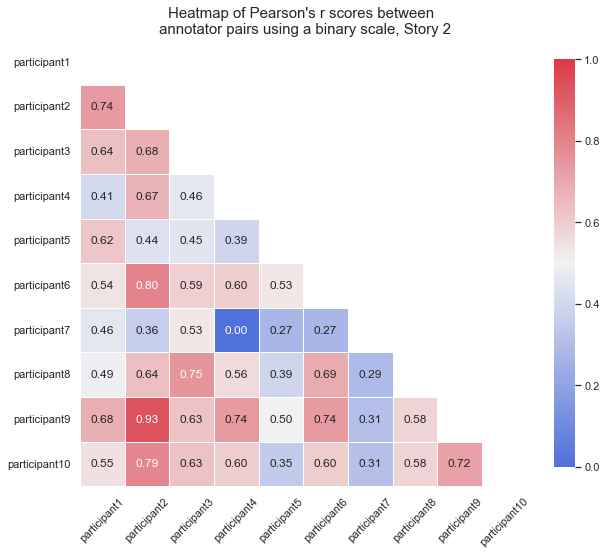

In [58]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          pearsons_values,
                                                          annotators,
                                                          "Heatmap of Pearson's r scores between \n annotator pairs using a binary scale, Story 2")



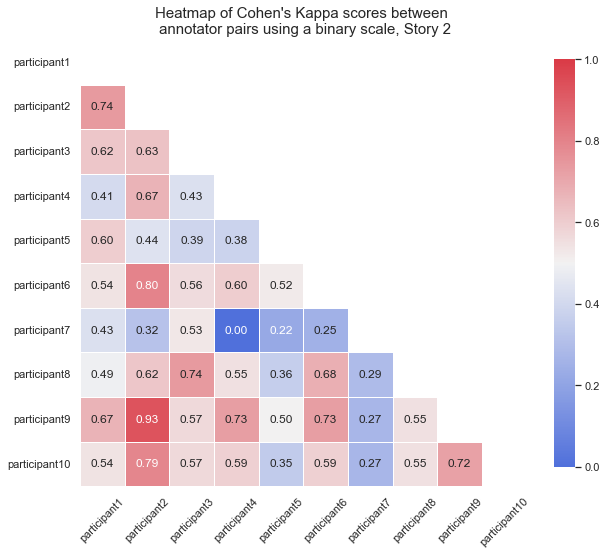

In [59]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          CKappa_values,
                                                          annotators,
                                                          "Heatmap of Cohen's Kappa scores between \n annotator pairs using a binary scale, Story 2")



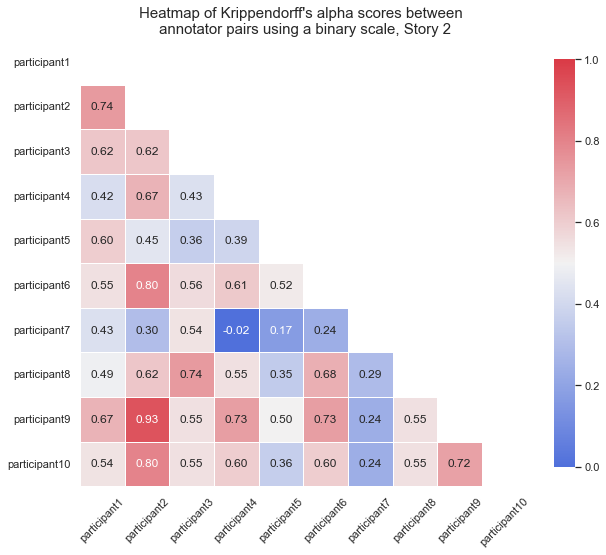

In [60]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          KA_values,
                                                          annotators,
                                                          "Heatmap of Krippendorff's alpha scores between \n annotator pairs using a binary scale, Story 2")
